#Once upon a Time-Series
###AR(1) Processes

This post is about AR(1) processes. What we find is that the AR(1) process doesn't actually bias our estimates of the coefficients. You can think of the AR(1) process as something that helps you patch up the standard errors when a time series "remembers" the past. This can be caused by unobserved variables changing slowly over time. I like to think of the AR(p) processes as echoes. Essentially, what we observe is some shock whose affect is felt today, tomorrow, and on ward forever because the echo isn't dampened. In order to pick out the true signal we need to correct for these echoes so that we see the signal correctly, so that the signal isn't distorted.

In [3]:
import pandas
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

Let's do some monte carlo simulations of some time-series with this property. We're going to look at positive autocorrelation, negative autocorrelation, and no autocorrelation. We're going to learn how to detect autocorrlation in a timeseries, and then we are going to see what happens when you don't correct for it, when you should and what will happen if you do correct for it when you shouldn't. So let's generate  a series with positive autocorrelation.

In [54]:
np.random.seed(992)
u=[]
x=[1]
y=[2]
u.append(np.random.normal(0,1))
rho=0.95
for i in range(1000):
    u.append(rho*u[i]+np.random.normal(0,20))
    x.append(np.random.normal(0,1))
    y.append(40+5.3*x[i+1]+u[i+1])
df=pandas.DataFrame([x,y]).T
df.columns=['x','y']
df['const']=1
df.head()

,x,y,const
0,1.000000,2.000000,1
1,-1.216810,20.749990,1
2,0.525834,26.110532,1
3,-0.767324,34.641265,1
4,-0.106521,-11.531330,1


The code above generates a dataset with two variables. One variable, x, is just a random noise process. We do this to guarantee that it is a stationary time series, i.e. it has no trend. The next variable, y, is a constant term, plus 5.3 times whatever x is, and an AR(1) process. The AR(1) process is our autocorrelation, above it is the term u. So we know for sure that y is also going to be stationary. We'll plot it below so that you can see.

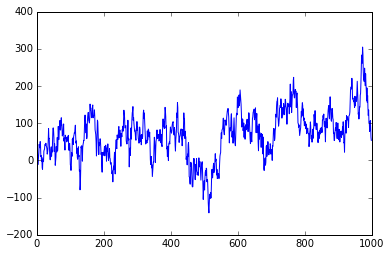

In [55]:
plt.plot(range(1000),df.loc[1:,'y'])
plt.show()

Next we'll plot the error term u over time so we can see what that AR(1) process looks like. I'm also going to zoom in on the first 100 observations to show you with some more clarity what is going on. But it looks like the timeseries sort of remembers what is going on.

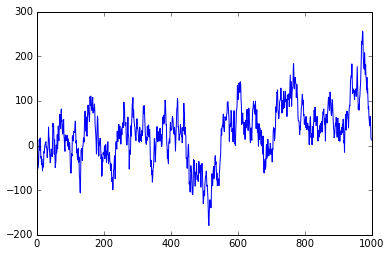

In [57]:
plt.plot(range(1000),u[1:])
plt.show()

It's still kind of hard to tell what is going on, but if you squint you can almost see it. The error seems to remember what it was doing. When it is negative, it likes to stay negative, and when it is positive it seems to like to stay positive. This "memory" is a problem when it comes to the basic assumptions about a regression. The different time periods shouldn't remember what happened to it before. In case this plot is too difficult to see the autocorrelation, the next chart is better.

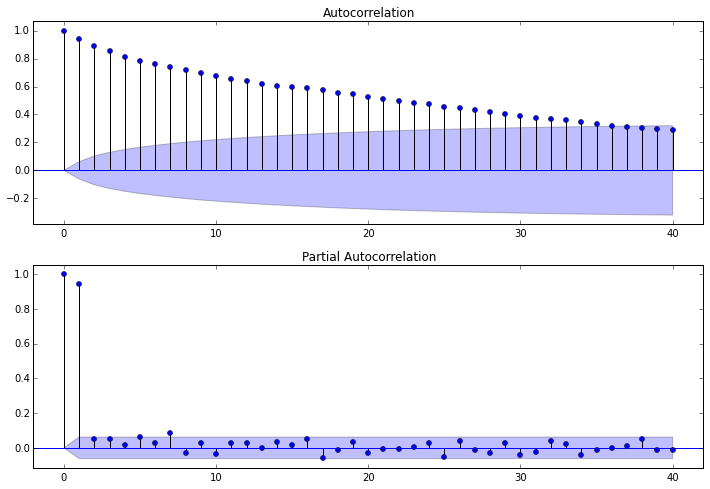

In [58]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.y.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.y.squeeze(), lags=40, ax=ax2)

These plots show the correlation coefficient on the error term with different lags. In other words, this is the autocorrelation. Now I find the partial autocorrelation easier to interpret but the same information is contained in both graphs. We have a very strong autocorrelation from only the first lag. Also a perfect correlation with the original observation, but we can ignore that because it is uniformative. 

In [59]:
y=df['y']
X=df[['x','const']]

model1=sm.OLS(y,X).fit()
print model1.summary()


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     20.22
Date:                Sat, 28 May 2016   Prob (F-statistic):           7.71e-06
Time:                        12:34:29   Log-Likelihood:                -5558.2
No. Observations:                1001   AIC:                         1.112e+04
Df Residuals:                     999   BIC:                         1.113e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x              9.2511      2.057      4.497      0.0

So this looks bad. I estimated the coefficient on x is 9.25, it should have been 5.3, and the constant should have been 40. And my standard errors are off, because I mispecificed the covariance matrix because of the autocorrelation. The tricky thing here is that I am technically, not biased in my coefficients, with more observations, I should get the correct coefficients.

In [60]:
from statsmodels.tsa import arima_model
df.index=pandas.date_range('2014-01-01',periods=len(df))
print df.head()
y=df['y']
X=df[['x']]
model2=arima_model.ARIMA(y,[1,0,0],X).fit()
print model2.summary()

                   x          y  const
2014-01-01  1.000000   2.000000      1
2014-01-02 -1.216810  20.749990      1
2014-01-03  0.525834  26.110532      1
2014-01-04 -0.767324  34.641265      1
2014-01-05 -0.106521 -11.531330      1
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1001
Model:                     ARMA(1, 0)   Log Likelihood               -4414.380
Method:                       css-mle   S.D. of innovations             19.883
Date:                Sat, 28 May 2016   AIC                           8836.760
Time:                        12:39:17   BIC                           8856.395
Sample:                    01-01-2014   HQIC                          8844.223
                         - 09-27-2016                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------

Notice that my coefficient on x is pretty good, so is my estimate of the amount of autocorrelation, 5.38 and 0.948 respectively. That's pretty close. My constant is still way off, and the true value falls outside of the 95% confidence interval. That's really too bad. But I am less confident about my answer for the constant and more confident about my coefficient on x. So that is some good news. Let's do the same thing with a slightly different seed, and negative autocorrelation. I'm going to blame the weird constant on the seed.

In [61]:
np.random.seed(993)
u=[]
x=[1]
y=[2]
u.append(np.random.normal(0,1))
rho=-0.95
for i in range(1000):
    u.append(rho*u[i]+np.random.normal(0,20))
    x.append(np.random.normal(0,1))
    y.append(40+5.3*x[i+1]+u[i+1])
df=pandas.DataFrame([x,y]).T
df.columns=['x','y']
df['const']=1
df.head()

,x,y,const
0,1.000000,2.000000,1
1,-1.101111,24.501892,1
2,-0.925462,41.993519,1
3,0.600197,0.390168,1
4,0.803091,88.901254,1


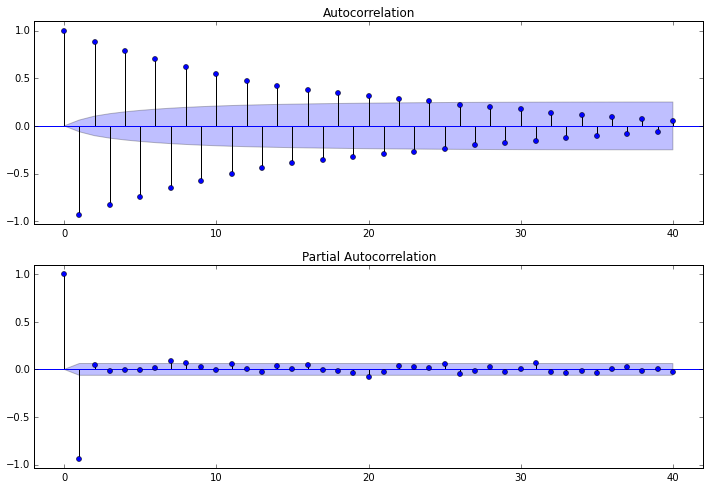

In [62]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.y.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.y.squeeze(), lags=40, ax=ax2)

So the swapping back and forth on the autocorrelation plot is actually the tell-tale sign of negative autocorrelation. The partial autocorrelation helps in making sure that I only have an AR(1) term, instead of say an AR(2).

In [63]:
y=df['y']
X=df[['x','const']]

model3=sm.OLS(y,X).fit()
print model3.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     9.413
Date:                Sat, 28 May 2016   Prob (F-statistic):            0.00221
Time:                        12:44:32   Log-Likelihood:                -5541.6
No. Observations:                1001   AIC:                         1.109e+04
Df Residuals:                     999   BIC:                         1.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x              5.8647      1.912      3.068      0.0

So I actually didn't do too bad here. I got 5.86 and 39.6 for the coefficient on x and the constant respectively, they are statistically significant too. A lot of people would call that a win. But because we can see that there is autocorrelation in the time series we know that we can do better.

In [64]:
from statsmodels.tsa import arima_model
df.index=pandas.date_range('2014-01-01',periods=len(df))
print df.head()
y=df['y']
X=df[['x']]
model4=arima_model.ARIMA(y,[1,0,0],X).fit()
print model4.summary()

                   x          y  const
2014-01-01  1.000000   2.000000      1
2014-01-02 -1.101111  24.501892      1
2014-01-03 -0.925462  41.993519      1
2014-01-04  0.600197   0.390168      1
2014-01-05  0.803091  88.901254      1
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1001
Model:                     ARMA(1, 0)   Log Likelihood               -4427.396
Method:                       css-mle   S.D. of innovations             20.144
Date:                Sat, 28 May 2016   AIC                           8862.791
Time:                        12:44:50   BIC                           8882.426
Sample:                    01-01-2014   HQIC                          8870.253
                         - 09-27-2016                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------

Look at how much more confident we are in these estimates! Again we see that the estimates are unbiased, we just screwed up the standard errors. Now let's look at one without any autocorrelation. What we'll see is that by adding an AR term inappropriately doesn't mess anything up because we just end up setting that autocorrelation coefficient to zero when we fit the model. So I won't dive into any explanation and just leave the numbers up for those that want to take a closer look.

In [46]:
np.random.seed(993)
u=[]
x=[1]
y=[2]
u.append(np.random.normal(0,1))
rho=0.0
for i in range(1000):
    u.append(rho*u[i]+np.random.normal(0,20))
    x.append(np.random.normal(0,1))
    y.append(40+5.3*x[i+1]+u[i+1])
df=pandas.DataFrame([x,y]).T
df.columns=['x','y']
df['const']=1
df.head()

,x,y,const
0,1.000000,2.000000,1
1,-1.101111,23.858743,1
2,-0.925462,32.814408,1
3,0.600197,6.943711,1
4,0.803091,48.249924,1


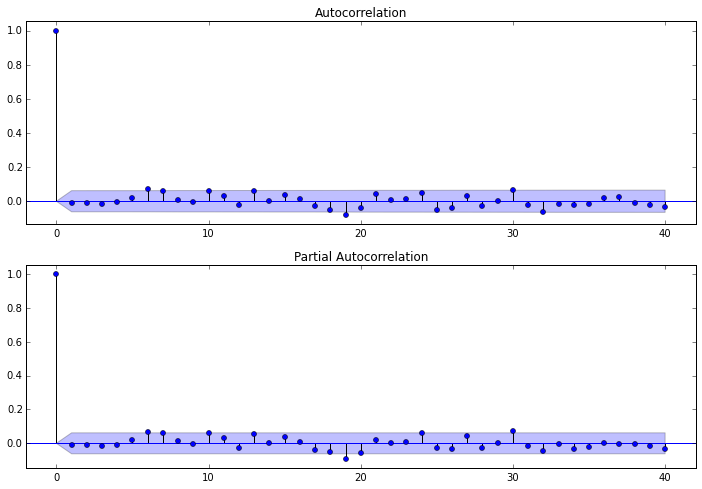

In [47]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.y.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.y.squeeze(), lags=40, ax=ax2)

In [48]:
y=df['y']
X=df[['x','const']]

model5=sm.OLS(y,X).fit()
print model5.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     80.54
Date:                Sat, 28 May 2016   Prob (F-statistic):           1.38e-18
Time:                        08:02:00   Log-Likelihood:                -4425.6
No. Observations:                1001   AIC:                             8855.
Df Residuals:                     999   BIC:                             8865.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x              5.6264      0.627      8.975      0.0

In [49]:
from statsmodels.tsa import arima_model
df.index=pandas.date_range('2014-01-01',periods=len(df))
print df.head()
y=df['y']
X=df[['x']]
model6=arima_model.ARIMA(y,[1,0,0],X).fit()
print model6.summary()

                   x          y  const
2014-01-01  1.000000   2.000000      1
2014-01-02 -1.101111  23.858743      1
2014-01-03 -0.925462  32.814408      1
2014-01-04  0.600197   6.943711      1
2014-01-05  0.803091  48.249924      1
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1001
Model:                     ARMA(1, 0)   Log Likelihood               -4425.548
Method:                       css-mle   S.D. of innovations             20.130
Date:                Sat, 28 May 2016   AIC                           8859.096
Time:                        08:02:51   BIC                           8878.731
Sample:                    01-01-2014   HQIC                          8866.558
                         - 09-27-2016                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------